In [1]:
# Import standard Python modules.
import datetime
import importlib
import os
import platform
import sys

# Import 3rd-party modules.
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Import TensorFlow.
import tensorflow as tf

In [2]:
# Use 64-bit math in TensorFlow.
tf.keras.backend.set_floatx('float64')

# Introduction

This notebook will illustrate how to solve a 1-D adiabatic compressible fluid flow boundary value problem using TensorFlow. The problem is developed in Pen *et al* (2003).

## The 1-D adiabatic compressible fluid flow problem

This PDE was selected as an intermediate step for solving the 1-D MHD equations. The fluid equations for adiabatic flow of a compressible ideal fluid are the *continuity equation*:

\begin{equation}
    \frac {\partial \rho} {\partial t} + \nabla \cdot (\rho \mathbf u) = 0
\end{equation}

the *momentum equation*:

\begin{equation}
    \rho \frac {D \mathbf u} {\partial t} + \nabla P = 0
\end{equation}

and the *energy equation* for adiabatic flow:

\begin{equation}
    \frac {D \left( P \rho^{-\gamma} \right)} {D t} = 0
\end{equation}

where $\rho$ is the mass density, $\mathbf u$ is the fluid velocity, $P$ is the isotropic pressure, and $\gamma$ is the adiabatic index. $D$ is the convective derivative operator:

\begin{equation}
    \frac {D} {D t} = \frac {\partial} {\partial t} + \mathbf u \cdot \nabla
\end{equation}

In the case of 1-D subsonic flow, these equations reduce to:

\begin{equation}
    \frac {\partial \rho} {\partial t} + \rho \frac {\partial u} {\partial x} + u \frac {\partial \rho} {\partial x} = 0
\end{equation}

\begin{equation}
    \rho \left( \frac {\partial u} {\partial t} + u \frac {\partial u} {\partial x} \right) + \frac {\partial P} {\partial x} = 0
\end{equation}

\begin{equation}
    \frac {D \left(P \rho^{-\gamma} \right)} {Dt} = 0
\end{equation}

where $\gamma$ is the adiabatic index.

At steady state, all time derivatives vanish, leaving:

\begin{equation}
    \rho \frac {d u} {d x} + u \frac {d \rho} {d x} = 0
\end{equation}

\begin{equation}
    \rho u \frac {d u} {d x} + \frac {d P} {d x} = 0
\end{equation}

\begin{equation}
    -\frac {\gamma P} {\rho} \frac {d \rho} {d x} + \frac {d P} {d x} = 0
\end{equation}


If $\frac {d P} {d x}$ is specified, this system of equations has the analytical solution

\begin{equation}
    \rho(x) = \left( \rho(0)^\gamma + \frac {C_2} {C_1} x \right)^{1/\gamma} \\
    u(x) = \sqrt { -\frac {2 C_1} {1 - 1/\gamma} \left( \rho(0)^\gamma + \frac {C_2} {C_1} x \right)^{1-1/\gamma} + 2 C_3}
\end{equation}

where the constants are:

\begin{equation}
    C_1 = \frac {P_0} {\rho_0^\gamma} \\
    C_2 = \frac {d P} {d x} \\
    C_3 = \frac {1} {2} \left( u(0)^2 + \frac {2 C_1} {1 - 1/\gamma} \rho(0)^{\gamma - 1}\right)
\end{equation}

Consider the initial conditions at $x=0$:

\begin{equation}
    \rho_0 = 1, u_0 = 1, P_0 = 1, \gamma = \frac {5} {3}, \frac {d P} {d x} = -0.1
\end{equation}

resulting in the constants:

\begin{equation}
    C_1 = 1 \\
    C_2 = -0.1 \\
    C_3 = 3
\end{equation}

The analytical solutions are shown below.

In [3]:
# Define functions for analytical solutions.

rho0 = 1
u0 = 1
P0 = 1
dP_dx = -0.1
gamma = 5/3

C1 = P0/rho0**gamma
C2 = dP_dx
C3 = 0.5*(u0**2 + 2*C1/(1 - 1/gamma)*rho0**(gamma-1))

def rho_a(x):
    return (rho0**gamma + C2/C1*x)**(1/gamma)

def u_a(x):
    return np.sqrt(-2*C1/(1 - 1/gamma)*(rho0**gamma + C2/C1*x)**(1 - 1/gamma) + 2*C3)

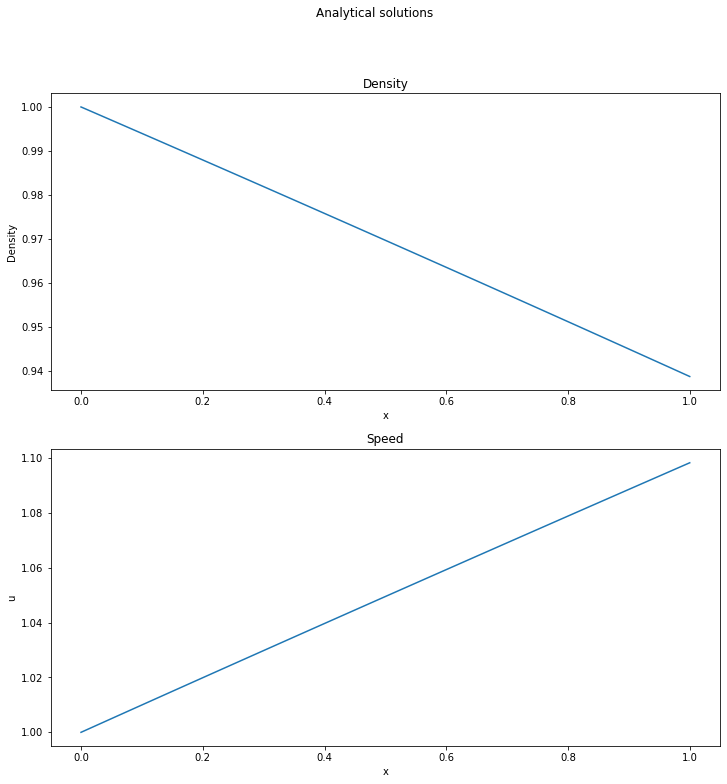

In [4]:
# Plot the analytical solutions.
x = np.linspace(0, 1, 101)

plt.figure(figsize=(12, 12))

# Pressure
# plt.subplot(211)
# plt.plot(x, P_a(x))
# plt.xlabel("x (m)")
# plt.ylabel("P (Pa)")
# plt.title("Pressure")

# Density
plt.subplot(211)
plt.plot(x, rho_a(x))
plt.xlabel("x")
plt.ylabel("Density")
plt.title("Density")

# Temperature
# plt.subplot(223)
# plt.plot(x, T_a(x))
# plt.xlabel("x (m)")
# plt.ylabel("Temperature (K)")
# plt.title("Temperature")

# Speed
plt.subplot(212)
plt.plot(x, u_a(x), label="u(x)")
# plt.plot(x, cs_a(x), label="cs(x)")
# plt.legend()
plt.xlabel("x")
plt.ylabel("u")
plt.title("Speed")

plt.suptitle("Analytical solutions")
plt.subplots_adjust(hspace=0.2)
plt.show()

# Solving with TensorFlow

In [5]:
def print_system_information():
    print("System report:")
    print(datetime.datetime.now())
    print("Host name: %s" % platform.node())
    print("OS: %s" % platform.platform())
    print("uname:", platform.uname())
    print("Python version: %s" % sys.version)
    print("Python build:", platform.python_build())
    print("Python compiler: %s" % platform.python_compiler())
    print("Python implementation: %s" % platform.python_implementation())
    # print("Python file: %s" % __file__)

In [6]:
def create_output_directory(path=None):
    path_noext, ext = os.path.splitext(path)
    output_dir = path_noext
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    return output_dir

In [7]:
from nnde.math.trainingdata import create_training_grid2

def create_training_data(*n_train):
    x_train = np.array(create_training_grid2(*n_train))
    return x_train

In [8]:
def build_model(H, w0_range, u0_range, v0_range):
    hidden_layer = tf.keras.layers.Dense(
        units=H, use_bias=True,
        activation=tf.keras.activations.sigmoid,
        kernel_initializer=tf.keras.initializers.RandomUniform(*w0_range),
        bias_initializer=tf.keras.initializers.RandomUniform(*u0_range)
    )
    output_layer = tf.keras.layers.Dense(
        units=1,
        activation=tf.keras.activations.linear,
        kernel_initializer=tf.keras.initializers.RandomUniform(*v0_range),
        use_bias=False,
    )
    model = tf.keras.Sequential([hidden_layer, output_layer])
    return model

In [9]:
print_system_information()

System report:
2022-01-07 15:08:58.673186
Host name: C02DT5CZMD6T-ML
OS: macOS-10.16-x86_64-i386-64bit
uname: uname_result(system='Darwin', node='C02DT5CZMD6T-ML', release='20.6.0', version='Darwin Kernel Version 20.6.0: Tue Oct 12 18:33:42 PDT 2021; root:xnu-7195.141.8~1/RELEASE_X86_64', machine='x86_64', processor='i386')
Python version: 3.8.12 (default, Oct 12 2021, 06:23:56) 
[Clang 10.0.0 ]
Python build: ('default', 'Oct 12 2021 06:23:56')
Python compiler: Clang 10.0.0 
Python implementation: CPython


In [10]:
# Set up the output directory.
eq_name = "1d_fluid_bvp"
path = os.path.join(".", eq_name)
output_dir = create_output_directory(path)

In [59]:
# Define the hyperparameters.

# Training optimizer
optimizer_name = "Adam"

# Initial parameter ranges
w0_range = [-0.1, 0.1]
u0_range = [-0.1, 0.1]
v0_range = [-0.1, 0.1]

# Maximum number of training epochs.
max_epochs = 10000

# Learning rate.
learning_rate = 0.01

# Absolute tolerance for consecutive loss function values to indicate convergence.
tol = 1e-8

# Number of hidden nodes.
H = 40

# Number of dimensions
m = 2

# Number of training points in each dimension.
nx_train = 11
nt_train = 11
n_train = nx_train*nt_train

# Number of validation points in each dimension.
nx_val = 21
nt_val = 21
n_val = nx_val*nt_val

# Random number generator seed.
random_seed = 0

In [60]:
# Create and save the training data.
xt_train = create_training_data(nx_train, nt_train)
x_train = xt_train[::nt_train, 0]
t_train = xt_train[:nt_train, 1]
np.savetxt(os.path.join(output_dir,'xt_train.dat'), xt_train)

# Create and save the validation data.
xt_val = create_training_data(nx_val, nt_val)
x_val = xt_val[::nt_val, 0]
t_val = xt_val[:nt_val, 1]
np.savetxt(os.path.join(output_dir, 'xt_val.dat'), xt_val)

In [61]:
# Define the differential equations using TensorFlow operations.

@tf.function
def pde1(x, rho, u, drho_dx, du_dx):
    return rho*du_dx + u*drho_dx

@tf.function
def pde2(x, rho, u, drho_dx, du_dx):
    return rho*u*du_dx + dP_dx

In [62]:
# Compute the outlet conditions.
rho1 = rho_a(1)
u1 = u_a(1)

In [63]:
# Define the trial functions.

@tf.function
def rho_trial(x, t, N):
    A = (1 - x)*rho0 + x*rho1
    P = x*(1 - x)
    rho = A + P*N[:, 0]
    return rho

@tf.function
def u_trial(x, t, N):
    A = (1 - x)*u0 + x*u1
    P = x*(1 - x)
    u = A + P*N[:, 0]
    return u

In [64]:
# Build the models.
model_rho = build_model(H, w0_range, u0_range, v0_range)
model_u = build_model(H, w0_range, u0_range, v0_range)

# Create the optimizers.
optimizer_rho = tf.keras.optimizers.Adam(learning_rate=learning_rate)
optimizer_u = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Train the models.

# Create history variables.
losses1 = []
losses2 = []
losses = []
phist_rho = []
phist_u = []

# Set the random number seed for reproducibility.
tf.random.set_seed(random_seed)

# Rename the training data Variable (_v) for convenience, just for training.
# shape (n_train, m)
xt_train_var = tf.Variable(xt_train, name="xt_train")
xt = xt_train_var
x = xt[:, 0]
t = xt[:, 1]

# Clear the convergence flag to start.
converged = False

print("Hyperparameters: n_train = %s, H = %s, max_epochs = %s, optimizer = %s, learning_rate = %s"
      % (n_train, H, max_epochs, optimizer_name, learning_rate))
t_start = datetime.datetime.now()
print("Training started at", t_start)

for epoch in range(max_epochs):

    # Run the forward pass.
    with tf.GradientTape(persistent=True) as tape1:
        with tf.GradientTape(persistent=True) as tape0:

            # Compute the network outputs at the training points.
            N_rho = model_rho(xt)
            N_u = model_u(xt)

            # Compute the trial solutions.
            Y_rho = rho_trial(x, t, N_rho)
            Y_u = u_trial(x, t, N_u)

        # Compute the gradients of the trial solutions wrt inputs.
        delY_rho = tape0.gradient(Y_rho, xt)
        dY_rho_dx = delY_rho[:, 0]
        delY_u = tape0.gradient(Y_u, xt)
        dY_u_dx = delY_u[:, 0]

        # Compute the estimates of the differential equations.
        G1 = pde1(x, Y_rho, Y_u, dY_rho_dx, dY_u_dx)
        G2 = pde2(x, Y_rho, Y_u, dY_rho_dx, dY_u_dx)

        # Compute the loss functions.
        L1 = tf.math.sqrt(tf.reduce_sum(G1**2)/n_train)
        L2 = tf.math.sqrt(tf.reduce_sum(G2**2)/n_train)
        L = L1 + L2

    # Save the current losses.
    losses1.append(L1.numpy())
    losses2.append(L2.numpy())
    losses.append(L.numpy())

    # Check for convergence.
    if epoch > 0:
        loss_delta = losses[-1] - losses[-2]
        if abs(loss_delta) <= tol:
            converged = True
            break

    # Compute the gradient of the loss function wrt the network parameters.
    pgrad_rho = tape1.gradient(L, model_rho.trainable_variables)
    pgrad_u = tape1.gradient(L, model_u.trainable_variables)

    # Save the parameters used in this epoch.
    phist_rho.append(
        np.hstack(
            (model_rho.trainable_variables[0].numpy().reshape((2*H,)),    # w (2, H) matrix -> (2H,) row vector
             model_rho.trainable_variables[1].numpy(),       # u (H,) row vector
             model_rho.trainable_variables[2][:, 0].numpy()) # v (H, 1) column vector
        )
    )
    phist_u.append(
        np.hstack(
            (model_u.trainable_variables[0].numpy().reshape((2*H,)),    # w (2, H) matrix -> (2H,) row vector
             model_u.trainable_variables[1].numpy(),       # u (H,) row vector
             model_u.trainable_variables[2][:, 0].numpy()) # v (H, 1) column vector
        )
    )

    # Update the parameters for this epoch.
    optimizer_rho.apply_gradients(zip(pgrad_rho, model_rho.trainable_variables))
    optimizer_u.apply_gradients(zip(pgrad_u, model_u.trainable_variables))

    if epoch % 100 == 0:
        print("Ending epoch %s, loss functions = (%f, %f, %f)" % (epoch, L1.numpy(), L2.numpy(), L.numpy()))

# Save the parameters used in the last epoch.
phist_rho.append(
    np.hstack(
        (model_rho.trainable_variables[0].numpy().reshape((2*H,)),    # w (2, H) matrix -> (2H,) row vector
         model_rho.trainable_variables[1].numpy(),       # u (H,) row vector
         model_rho.trainable_variables[2][:, 0].numpy()) # v (H, 1) column vector
    )
)
phist_u.append(
    np.hstack(
        (model_u.trainable_variables[0].numpy().reshape((2*H,)),    # w (2, H) matrix -> (2H,) row vector
         model_u.trainable_variables[1].numpy(),       # u (H,) row vector
         model_u.trainable_variables[2][:, 0].numpy()) # v (H, 1) column vector
    )
)

n_epochs = epoch + 1

t_stop = datetime.datetime.now()
print("Training stopped at", t_stop)
t_elapsed = t_stop - t_start
print("Total training time was %s seconds." % t_elapsed.total_seconds())
print("Epochs: %d" % n_epochs)
print("Final value of loss function: %f" % losses[-1])
print("converged = %s" % converged)

# Save the parameter histories.
np.savetxt(os.path.join(output_dir, 'phist_rho.dat'), np.array(phist_rho))
np.savetxt(os.path.join(output_dir, 'phist_u.dat'), np.array(phist_u))

Hyperparameters: n_train = 121, H = 40, max_epochs = 10000, optimizer = Adam, learning_rate = 0.01
Training started at 2022-01-07 15:34:56.624468
Ending epoch 0, loss functions = (0.001176, 0.099628, 0.100804)
Ending epoch 100, loss functions = (0.002759, 0.052846, 0.055605)
Ending epoch 200, loss functions = (0.002602, 0.048988, 0.051590)
Ending epoch 300, loss functions = (0.002138, 0.047238, 0.049376)
Ending epoch 400, loss functions = (0.002731, 0.046426, 0.049158)
Training stopped at 2022-01-07 15:35:04.114664
Total training time was 7.490196 seconds.
Epochs: 423
Final value of loss function: 0.049144
converged = True


In [65]:
# Compute and save the trained results at training points.
with tf.GradientTape(persistent=True) as tape0:
    N_rho = model_rho(xt)
    N_u = model_u(xt)
    rho_train = rho_trial(x, t, N_rho)
    u_train = u_trial(x, t, N_u)
delrho = tape0.gradient(rho_train, xt)
drho_dx_train = delrho[:, 0]
drho_dt_train = delrho[:, 1]
delu = tape0.gradient(u_train, xt)
du_dx_train = delu[:, 0]
du_dt_train = delu[:, 1]

np.savetxt(os.path.join(output_dir, 'rho_train.dat'), rho_train.numpy().reshape((n_train)))
np.savetxt(os.path.join(output_dir, 'drho_dx_train.dat'), drho_dx_train.numpy())
np.savetxt(os.path.join(output_dir, 'drho_dt_train.dat'), drho_dt_train.numpy())

np.savetxt(os.path.join(output_dir, 'u_train.dat'), u_train.numpy().reshape((n_train)))
np.savetxt(os.path.join(output_dir, 'du_dx_train.dat'), du_dx_train.numpy().reshape((n_train)))
np.savetxt(os.path.join(output_dir, 'du_dt_train.dat'), du_dt_train.numpy().reshape((n_train)))

# # Compute and save the analytical solution and derivatives at training points.
# Ya_train = np.array([eq.Ya(xy) for xy in xy_train])
# dYa_dx_train = np.array([eq.dYa_dx(xy) for xy in xy_train])
# dYa_dy_train = np.array([eq.dYa_dy(xy) for xy in xy_train])
# d2Ya_dx2_train = np.array([eq.d2Ya_dx2(xy) for xy in xy_train])
# d2Ya_dy2_train = np.array([eq.d2Ya_dy2(xy) for xy in xy_train])
# np.savetxt(os.path.join(output_dir,'Ya_train.dat'), Ya_train)
# np.savetxt(os.path.join(output_dir,'dYa_dx_train.dat'), dYa_dx_train)
# np.savetxt(os.path.join(output_dir,'dYa_dy_train.dat'), dYa_dy_train)
# np.savetxt(os.path.join(output_dir,'d2Ya_dx2_train.dat'), d2Ya_dx2_train)
# np.savetxt(os.path.join(output_dir,'d2Ya_dy2_train.dat'), d2Ya_dy2_train)

# # Compute and save the error in the trained solution and derivatives at training points.
# Yt_err_train = Yt_train.numpy() - Ya_train
# dYt_dx_err_train = dYt_dx_train.numpy() - dYa_dx_train
# dYt_dy_err_train = dYt_dx_train.numpy() - dYa_dy_train
# d2Yt_dx2_err_train = d2Yt_dx2_train.numpy() - d2Ya_dx2_train
# d2Yt_dy2_err_train = d2Yt_dx2_train.numpy() - d2Ya_dy2_train
# np.savetxt(os.path.join(output_dir, 'Yt_err_train.dat'), Yt_err_train)
# np.savetxt(os.path.join(output_dir, 'dYt_dx_err_train.dat'), dYt_dx_err_train)
# np.savetxt(os.path.join(output_dir, 'dYt_dy_err_train.dat'), dYt_dy_err_train)
# np.savetxt(os.path.join(output_dir, 'd2Yt_dx2_err_train.dat'), d2Yt_dx2_err_train)
# np.savetxt(os.path.join(output_dir, 'd2Yt_dy2_err_train.dat'), d2Yt_dy2_err_train)

# # Compute the final RMS errors.
# Yt_rmse_train = np.sqrt(np.sum(Yt_err_train**2)/n_train)
# print("Yt_rmse_train = %s" % Yt_rmse_train)

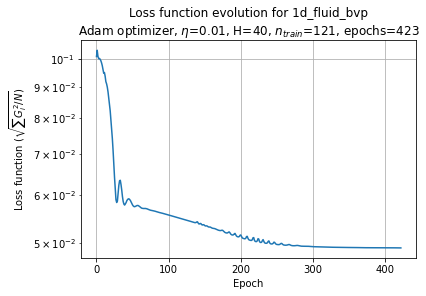

In [66]:
# Plot the loss function history.
plt.semilogy(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss function ($\sqrt {\sum G_i^2/N}$)")
plt.grid()
plt.title("Loss function evolution for %s\n%s optimizer, $\eta$=%s, H=%s, $n_{train}$=%s, epochs=%s" %
          (eq_name, optimizer_name, learning_rate, H, n_train, n_epochs))
plt.show()